# Filter out tracks based on criteria

In [1]:
import pandas as pd 
import numpy as np 
import sys
sys.path.append('../src/')
from filters import Track, create_tracks_from_dataframe, drop_short_tracks
from filters import drop_early_peak_tracks, drop_last_frame_peak_tracks, drop_tracks_below_intensity
from filters import plot_z_sum, allocate_membrane_regions, plot_z_sum_bd
import napari
import zarr
import dask.array as da
import os

### Do not change the code in the cell below 

In [2]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'track_df_cleaned_final_full.pkl'
input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = 'filtered_tracks_final.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [3]:
track_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')


This notebook extracts tracks for the following channel combinations
1. Channel 1, Channel 2 and Channel 3 all positive
2. Channel 1 and Channel 3 positive 
3. Channel 2 and Channel 3 positive 

To come up with the correct tracks multiple user input are needed. 

Parameters required to update
1. **threshold** in drop_short_tracks():  Tracks with length below and including this threshold value are dopped 
2. **cutoff** in drop_early_peak_tracks(): This looks at the frame on which peak value of the amplitude/intensity of a track for a specific channel is reached. If cutoff is 3, the track which have peak for a specific channel below or at the third frame will not be considered as positive for that channel. This step is done for all the channels. 
3. **threshold** in drop_tracks_below_intensity(): This is the minimum intensity value that a specific channel within a track must achieve to be considered positive for that channel. You can link this to spot_intensity from notebook 01. Where anything below spot_intensity is considered as noise, likewise for threshold if a spot does not reach a specific intensity for a specific channel it means that the track is not positive in that channel and its only noise. This step is done for the two channels apart from the one on which detection is performed. For example in this case detection is performed on channel 3 so **drop_tracks_below_intensity()** needs to be perfomed on channel 1 and channel 2. The threshold value for both channels will be different and can be decided through visualisation in Napari. 


Lastly, this notebook allows you to set assign membrane region to the tracks (apical,basal,lateral), if your cell has any. If you cell does not then it will assign all tracks to basal region and you can ignore this column in the next steps. 

In [4]:
# Setup the parameters in this step 

threshold_length = 3 # this is the first threshold explained above 
peak_cutoff = 3 # this is the second parameter explained above 
threshold_intensity_channel_1 = 240 # this is the the third parameter explained above 
threshold_intensity_channel_2 = 150 # this is the the third parameter explained above 

membrane_regions_exist = True # set this to false if no membrane regions exist 


In [6]:
tracks = create_tracks_from_dataframe(df = track_df, intensities_col_name = ['c3_peak_mean', 'c2_peak_mean', 'c1_peak_mean'], 
track_id_col_name = 'track_id', frame_col_name = 'frame', coords = ['mu_x', 'mu_y', 'mu_z'])

In [7]:
# Create DataFrame from Track instances
tracks_data = {
    'track_id': [track.track_id.values[0] for track in tracks],
    'track_length': [track.track_length for track in tracks],
    'track_start': [track.track_start for track in tracks],
    'track_end': [track.track_end for track in tracks],
    'c3_peak': [track.peak_intensities[0] for track in tracks],
    'c2_peak': [track.peak_intensities[1] for track in tracks],
    'c1_peak': [track.peak_intensities[2] for track in tracks],
    'c3_peak_frame': [track.peak_intensity_frames[0] for track in tracks],
    'c2_peak_frame': [track.peak_intensity_frames[1] for track in tracks],
    'c1_peak_frame': [track.peak_intensity_frames[2] for track in tracks],
    'mean_displacement': [track.mean_displacement_track for track in tracks],
    'mean_z': [track.mean_z_value for track in tracks],
    'mean_z_displacement': [track.mean_z_displacement for track in tracks], 
    'max_radius_from_origin': [track.max_radius_from_origin for track in tracks], 
    'max_distance_between_two_points': [track.max_distance_between_two_points for track in tracks], 
    'C3_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[0] for track in tracks],
    'C2_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[1] for track in tracks],
    'C1_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[2] for track in tracks],
    'max_z_movement': [track.max_z_movement for track in tracks],
    'max_y_movement': [track.max_y_movement for track in tracks],
    'max_x_movement': [track.max_x_movement for track in tracks],
}

tracks_df = pd.DataFrame(tracks_data)

Filter out tracks based on criteria

In [10]:
#dropping tracks of length 3 and below
length_filtered_tracks_df = drop_short_tracks(df = tracks_df, threshold = threshold_length)

# Drop incomplete tracks (starting at first frame or ending at last frame)
incomplete_tracks_df = tracks_df.loc[(tracks_df['track_start'] == 0) | (tracks_df['track_end'] == track_df['frame'].max())]
tracks_df = tracks_df.drop(incomplete_tracks_df.index)


Determining Valid Channel 3 tracks 

In [13]:
### Dropping tracks with Channel 3 peak in the last frame
valid_c3_tracks = drop_last_frame_peak_tracks(df = length_filtered_tracks_df, intensity_col = 'c3_peak_frame')

### Dropping tracks with Channel 3 which have their peaks in the first three frames 

valid_c3_tracks = drop_early_peak_tracks(df = valid_c3_tracks, intensity_peak_frame = 'c3_peak_frame', 
                                      cutoff = peak_cutoff)

**valid_c3_tracks will serve as baseline "clathrin positive" and valid tracks**

Filtering for Channel 2 

In [14]:
# Channel 2-positive tracks

dnm2_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = threshold_intensity_channel_2, 
                                          intensity_peak_frame = 'c2_peak')

### Filter tracks based on channel 2 peak if occurs within 3 frames of starting of a track 

dnm2_positive_tracks = drop_early_peak_tracks(df = dnm2_positive_tracks, intensity_peak_frame = 'c2_peak_frame', 
                                      cutoff = peak_cutoff)

### Filter tracks based on channel 2 peaks occuring in the last frame 

dnm2_positive_tracks = drop_last_frame_peak_tracks(df = dnm2_positive_tracks, intensity_col = 'c2_peak_frame')
dnm2_positive_tracks.shape

(475, 21)

**dnm2_positive_tracks will serve as the baseline for dynamin positive tracks**

In [16]:
# Identifying Channel 1 (Actin) positive tracks 
### Identifying Actin Positive Tracks 
actin_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = threshold_intensity_channel_1, 
                                          intensity_peak_frame = 'c1_peak' )

### Filter tracks based on channel 1 peaks if occurs within the first 3 frames 

actin_positive_tracks = drop_early_peak_tracks(df = actin_positive_tracks, intensity_peak_frame = 'c1_peak_frame', 
                                      cutoff = peak_cutoff)

actin_positive_tracks = drop_last_frame_peak_tracks(df = actin_positive_tracks, intensity_col = 'c1_peak_frame')

Combining actin and dynamin positive tracks with valid clathrin positive tracks 

In [17]:
final_tracks = valid_c3_tracks.copy(deep = True)
final_tracks['channel2_positive'] = False 
final_tracks['channel1_positive'] = False 

In [18]:
# ***Setting actin positive tracks to True***

# Get the track IDs from actin_positive_tracks
actin_positive_track_ids = actin_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(actin_positive_track_ids), 'channel1_positive'] = True

actin_rows_count = final_tracks[final_tracks['channel1_positive'] == True].shape[0]
print(f'number of actin positive tracks are: {actin_rows_count}')

# ***Setting dynamin positive tracks to True***

# Get the track IDs from actin_positive_tracks
dnm2_positive_track_ids = dnm2_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(dnm2_positive_track_ids), 'channel2_positive'] = True

dnm2_rows_count = final_tracks[final_tracks['channel2_positive'] == True].shape[0]
print(f'number of dynamin positive tracks are: {dnm2_rows_count}')

actin_dnm2_rows_count = final_tracks[(final_tracks['channel2_positive'] == True) & 
                                     (final_tracks['channel1_positive'] == True)].shape[0]
print(f'number of dynamin and actin positive tracks are: {actin_dnm2_rows_count}')

number of actin positive tracks are: 1492
number of dynamin positive tracks are: 475
number of dynamin and actin positive tracks are: 365


# Allocating Apical/Basal/Lateral boundaries to tracks
Using channel 1 (actin) for this purpose 

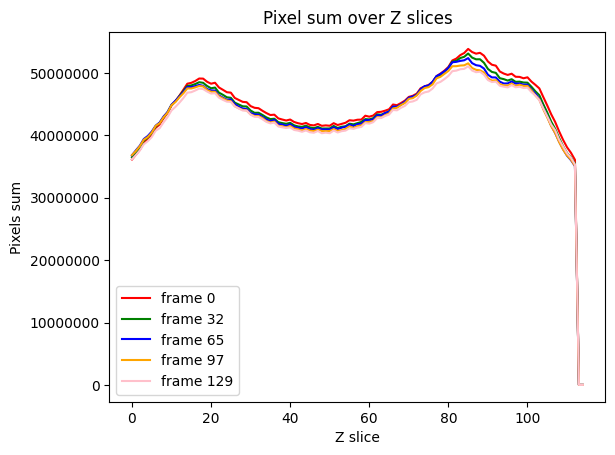

In [19]:
#channel is hard coded in the function right now. Need to allow it to be passed as a parameter by the user 
if membrane_regions_exist == True:      
    plot_z_sum_bd(z2)

This Z axis plot shows where the max intensities are, which roughly correspond to the basal and apical regions of the cell. 
Use this plot and scan through the z series in Napari below to determine the cutoff Z slice values for basal, lateral, and apical regions of the cell

In [28]:
if membrane_regions_exist == True: 
    allocate_membrane_regions(df = final_tracks, basal_range = [0,25] , lateral_range = [25,75], apical_range = [75,112])

else: 
    final_tracks['membrane_region'] = 'Basal'

Save tracks

In [ ]:
final_tracks.to_pickle(output_directory_full)

Traceback (most recent call last):
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_qt/qt_main_window.py", line 572, in closeEvent
    quit_app()
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_qt/qt_event_loop.py", line 232, in quit_app
    v.close()
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/viewer.py", line 146, in close
    self.window.close()
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_qt/qt_main_window.py", line 1525, in close
    self._qt_viewer.close()
RuntimeError: wrapped C/C++ object of type QtViewer has been deleted
Traceback (most recent call last):
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_qt/qt_main_window.py", line 572, in closeEvent
    quit_app()
  File "/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napa

: 

# Visualize tracks in Napari to assess track filtering quality

In [22]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['channel 1', 'channel 2', 'channel 3'])
#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

viewer.add_tracks(track_df[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'all tracks')

<Tracks layer 'all tracks' at 0x26ce5b970>

In [23]:
#Displaying Dynamin Positive tracks only (Tracks where actin is not present)
dnm2_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == True) & (final_tracks['channel1_positive'] == False)]
dnm2_tracks_list = dnm2_positive_tracks_df['track_id'].values
track_1 = track_df[track_df['track_id'].isin(dnm2_tracks_list)]
viewer.add_tracks(track_1[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'channel2+ tracks')

<Tracks layer 'channel2+ tracks' at 0x29d40ceb0>

In [24]:
#Displaying Actin Positive tracks only (Tracks where Dynamin is not present)
actin_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == False) & (final_tracks['channel1_positive'] == True)]
actin_tracks_list = actin_positive_tracks_df['track_id'].values
track_2 = track_df[track_df['track_id'].isin(actin_tracks_list)]
viewer.add_tracks(track_2[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'channel1+ tracks')

<Tracks layer 'channel1+ tracks' at 0x2a0b2de40>

In [25]:
#Displaying all 3 channels positive tracks 
all_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == True) & (final_tracks['channel1_positive'] == True)]
all_positive_tracks_list = all_positive_tracks_df['track_id'].values
track_3 = track_df[track_df['track_id'].isin(all_positive_tracks_list)]
viewer.add_tracks(track_3[["track_id", "frame","c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'all+ tracks')

<Tracks layer 'all+ tracks' at 0x29df23fd0>

In [30]:
#Displaying basal tracks 
if membrane_regions_exist == True: 
    basal_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Basal']
    basal_tracks_list = basal_tracks_df['track_id'].values
    track_4 = track_df[track_df['track_id'].isin(basal_tracks_list)]
    viewer.add_tracks(track_4[["track_id", "frame","c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'basal tracks')

In [31]:
#Displaying lateral tracks 
if membrane_regions_exist == True:
    lateral_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Lateral']
    lateral_tracks_list = lateral_tracks_df['track_id'].values
    track_5 = track_df[track_df['track_id'].isin(lateral_tracks_list)]
    viewer.add_tracks(track_5[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'Lateral tracks')

In [32]:
#Displaying apical tracks 
if membrane_regions_exist == True:
    apical_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Apical']
    apical_tracks_list = apical_tracks_df['track_id'].values
    track_6 = track_df[track_df['track_id'].isin(apical_tracks_list)]
    viewer.add_tracks(track_6[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'Apical tracks')

/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (115, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (115, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (115, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (115, 2052, 

### final_tracks dataframe stores tracks which are at least clathrin positive.

## Once you have performed this step and have filtered tracks  you can now use the dashboard to test performance of the pipeline and access visualisations. 

# Go to multipage_dashboard and run app.py 